In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN, Embedding
from keras.optimizers import RMSprop, SGD
from keras.models import load_model
import pickle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Initialize Config Variables
vocab_size = 8000
embedding_size = 16
batch_size = 16
n_hidden=128
n_visible=3

In [3]:
class WordEmbeddingRNN():
    def __init__(self, 
                vocab_size = 8000,
                embedding_size = 32,
                batch_size = 16,
                n_hidden=128,
                n_visible=3,
                reg_constant = 0.001,
                learning_rate = 0.001):
        self.model_path = "model_files/weights" + str(embedding_size) + ".{epoch:02d}-{val_loss:.2f}.hdf5"
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.n_visible = n_visible
        self.reg_constant = reg_constant
        
    def build_model(self):
        self.model = Sequential()
        self.model.add(Embedding(self.vocab_size, self.embedding_size,  embeddings_initializer='uniform', embeddings_regularizer=l2(self.reg_constant), activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=self.n_visible))
        self.model.add(SimpleRNN(self.n_hidden, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=l2(self.reg_constant), recurrent_regularizer=l2(self.reg_constant), bias_regularizer=l2(self.reg_constant), activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=True))
        # model.add(Flatten())
        # model.add(Dense(n_hidden, activation='tanh'))
        self.model.add(Dense(self.vocab_size, activation='softmax',use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=l2(self.reg_constant), bias_regularizer=l2(self.reg_constant), activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
    
    def config_model(self, learning_rate, reduce_factor):
        optimizer = Adam(lr=learning_rate)
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=reduce_factor, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
        self.checkpoint = ModelCheckpoint(self.model_path, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    
    def train_model(self,x_train,one_hoty_train, x_val, one_hot_y_val):
        self.history = self.model.fit(x_train, one_hot_y_train,
          batch_size=self.batch_size,
          epochs=100,
          validation_data=(x_val, one_hot_y_val),
          callbacks=[self.reduce_lr,self.checkpoint])
        
    def get_history(self):
        return self.history
    
    def plot_model(self):
        plot_model(self.model, to_file='model.png')
        Image(filename='model.png')

In [4]:
def get_sentences_list(text_file):
    sentences_list = []
    with open(text_file) as text:
        for sentence in text:
            sentence = sentence.lower()
            sentence = "START " + sentence + " END"
            sentence_list = sentence.split()
            sentences_list. append(sentence_list)
    return sentences_list

In [5]:
def get_input_output(sentences_list, n, vocabulary_dict):
    output = []
    input = []
    for sentence in sentences_list:
        for word_index in range(len(sentence) - n -1):
            input.append([vocabulary_dict[x] if x in vocabulary_dict else vocabulary_dict['UNK'] for x in sentence[word_index:word_index+n]] )
            output.append(vocabulary_dict[sentence[word_index + n]] if sentence[word_index+n] in vocabulary_dict else vocabulary_dict['UNK'] )
    # print output
    # print input
    return np.array(input), np.array(output)

In [6]:
vocabulary_dict = pickle.load(open('preprocessed_dict.p','rb'))
id_dict = {y:x for x,y in vocabulary_dict.iteritems()}

In [7]:
x_train, y_train = get_input_output(get_sentences_list('train.txt'), n_visible, vocabulary_dict)
x_val, y_val = get_input_output(get_sentences_list('val.txt'), n_visible, vocabulary_dict)
one_hot_y_train = keras.utils.to_categorical(y_train, num_classes=8000)
one_hot_y_val = keras.utils.to_categorical(y_val, num_classes=8000)
print y_train.shape
print x_train.shape


(82903,)
(82903, 3)


In [8]:
model = load_model('weights16.99-6.04.hdf5')

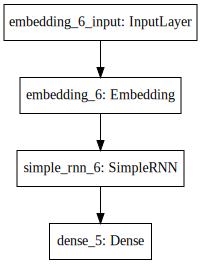

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [10]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)


In [88]:
for layer in model.layers:
    print layer.get_weights()[0].shape
    print layer.get_config()

(8000, 16)
{'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'maxval': 0.05, 'seed': None, 'minval': -0.05}}, 'name': u'embedding_6', 'dtype': u'float32', 'output_dim': 16, 'trainable': True, 'embeddings_regularizer': {'class_name': 'L1L2', 'config': {'l2': 0.0010000000474974513, 'l1': 0.0}}, 'input_dim': 8000, 'mask_zero': False, 'embeddings_constraint': None, 'batch_input_shape': (None, 3), 'activity_regularizer': None, 'input_length': 3}
(16, 128)
{'trainable': True, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'seed': None, 'gain': 1.0}}, 'use_bias': True, 'bias_regularizer': {'class_name': 'L1L2', 'config': {'l2': 0.0010000000474974513, 'l1': 0.0}}, 'return_state': False, 'unroll': True, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'units': 128, 'activity_regularizer': None, 'recurrent_dropout': 0.0, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'distribution': u'uniform', 'scale': 1.0, 'seed': None, 'mode'

In [171]:

def generate_sentences(three_word_list):
    for three_words in three_word_list:
        output_list = three_words
        c = 0
        output = ''
        while c < 10 and output != 'END':
            x = np.array([[vocabulary_dict[output_list[-3]],vocabulary_dict[output_list[-2]], vocabulary_dict[output_list[-1]]]])
        #     x = x_train[1:2]
#             print np.argmax(model.predict(x, batch_size=1, verbose=0)[0])
            output = id_dict[np.argmax(model.predict(x, batch_size=1, verbose=0)[0])]
            output_list.append(output)
            c+=1
        print output_list
#         sentences_list.append(' '.join(sentence))
        print ' '.join(output_list)
        

In [173]:
three_word_list = [['the','new', 'york'],['city','of','new'],['life', 'in', 'the'],['united','states','of'],['i','lost','my']]

generate_sentences(three_word_list)
# print output_list

['the', 'new', 'york', ',', 'the', 'UNK', 'of', 'the', 'UNK', 'of', 'the', 'UNK', 'of']
the new york , the UNK of the UNK of the UNK of
['city', 'of', 'new', 'york', ',', 'the', 'UNK', 'of', 'the', 'UNK', 'of', 'the', 'UNK']
city of new york , the UNK of the UNK of the UNK
['life', 'in', 'the', 'UNK', ',', "''", 'says', '0', '*t*-1', '.', "''", 'said', '0']
life in the UNK , '' says 0 *t*-1 . '' said 0
['united', 'states', 'of', 'the', 'UNK', 'of', 'the', 'UNK', 'of', 'the', 'UNK', 'of', 'the']
united states of the UNK of the UNK of the UNK of the
['i', 'lost', 'my', 'the', 'UNK', 'of', 'the', 'UNK', 'of', 'the', 'UNK', 'of', 'the']
i lost my the UNK of the UNK of the UNK of the


In [130]:
def difference_between_words(word1, word2, vocabulary_dict, word_embedding_weights):
    print word_embedding_weights[vocabulary_dict[word1]]
    print word_embedding_weights[vocabulary_dict[word2]]
    return difference_between_embeddings(word_embedding_weights[vocabulary_dict[word1]],word_embedding_weights[vocabulary_dict[word2]])

def difference_between_embeddings(embedding_one, embedding_two):
    euclidean_dist = np.linalg.norm(embedding_one - embedding_two)
    return euclidean_dist

In [128]:
word_embedding_weights = model.layers[0].get_weights()[0]

In [151]:
print difference_between_words('stock','exchange', vocabulary_dict, word_embedding_weights)

[  5.22842602e-05   4.10867520e-02   1.02738336e-01   1.79046147e-05
  -2.50138752e-02   8.53917096e-03  -2.72150133e-02   3.80369276e-02
  -2.60896911e-03   1.14270225e-02  -2.63578035e-02  -9.20016691e-02
   3.83291915e-02  -4.49371412e-02  -8.80436003e-02  -2.36374065e-02]
[ -3.95645839e-05  -1.75337866e-02   3.59031670e-02   2.36680848e-04
  -1.74732655e-02  -2.70102601e-02  -3.71757103e-03   5.61892847e-03
  -2.85587361e-04   5.09307440e-03  -2.65304595e-02  -1.83584038e-02
   6.55516936e-03  -7.96384066e-02  -3.53710018e-02  -2.76069734e-02]
0.145945


In [155]:
print difference_between_words('stock','price', vocabulary_dict, word_embedding_weights)

[  5.22842602e-05   4.10867520e-02   1.02738336e-01   1.79046147e-05
  -2.50138752e-02   8.53917096e-03  -2.72150133e-02   3.80369276e-02
  -2.60896911e-03   1.14270225e-02  -2.63578035e-02  -9.20016691e-02
   3.83291915e-02  -4.49371412e-02  -8.80436003e-02  -2.36374065e-02]
[  1.18011670e-07  -1.36980088e-03  -1.44338114e-02  -2.16358080e-06
   2.22762488e-03   2.51905993e-03  -3.88336852e-02  -2.80646589e-02
   1.95567310e-03  -5.40890684e-03   1.91920847e-02   5.94580285e-02
  -2.74382439e-02   1.49775501e-02   1.22387065e-02  -9.28732194e-03]
0.253597


In [154]:
print difference_between_words('stock','bottle', vocabulary_dict, word_embedding_weights)

[  5.22842602e-05   4.10867520e-02   1.02738336e-01   1.79046147e-05
  -2.50138752e-02   8.53917096e-03  -2.72150133e-02   3.80369276e-02
  -2.60896911e-03   1.14270225e-02  -2.63578035e-02  -9.20016691e-02
   3.83291915e-02  -4.49371412e-02  -8.80436003e-02  -2.36374065e-02]
[  1.91627828e-06  -8.42060521e-03  -7.24444017e-02  -2.50331177e-05
   2.57820543e-02  -6.26633409e-03   2.20071860e-02  -1.13242259e-03
  -6.75145056e-05  -3.11201118e-04  -1.41763156e-02   2.06105993e-03
  -1.14133162e-03  -3.55833545e-02   6.31558448e-02  -3.05776065e-03]
0.271969


In [159]:
print difference_between_words('stock','president', vocabulary_dict, word_embedding_weights)

[  5.22842602e-05   4.10867520e-02   1.02738336e-01   1.79046147e-05
  -2.50138752e-02   8.53917096e-03  -2.72150133e-02   3.80369276e-02
  -2.60896911e-03   1.14270225e-02  -2.63578035e-02  -9.20016691e-02
   3.83291915e-02  -4.49371412e-02  -8.80436003e-02  -2.36374065e-02]
[ -3.68407986e-04  -2.96845194e-02  -2.37140758e-03   1.10979468e-04
  -2.34217290e-02  -3.87106501e-02   6.44493029e-02  -7.08316937e-02
   6.00481546e-03  -7.86116626e-03  -1.17028050e-01   1.15702584e-01
  -6.75516948e-02  -2.55539000e-01  -1.15735587e-02  -6.24788515e-02]
0.391504


In [174]:
print difference_between_words('stock','UNK', vocabulary_dict, word_embedding_weights)

[  5.22842602e-05   4.10867520e-02   1.02738336e-01   1.79046147e-05
  -2.50138752e-02   8.53917096e-03  -2.72150133e-02   3.80369276e-02
  -2.60896911e-03   1.14270225e-02  -2.63578035e-02  -9.20016691e-02
   3.83291915e-02  -4.49371412e-02  -8.80436003e-02  -2.36374065e-02]
[  2.39142973e-05  -5.53090237e-02  -8.08851700e-03   6.01941247e-05
  -7.09278369e-03  -4.90426980e-02   2.92377267e-02   6.53747097e-02
  -3.71069252e-03   1.26294559e-02   7.28604058e-03  -1.38582632e-01
   6.41587675e-02  -1.55573925e-02   2.19248515e-03   2.81419634e-05]
0.206599


In [176]:
model2 = load_model('weights2.99-5.74.hdf5')

In [189]:
print model2.layers[0].get_weights()[0].shape
word_embedding =  model2.layers[0].get_weights()[0]
pickle.dump(word_embedding, open('word_embedding_weights128tanh2.p','wb'))

(8000, 2)


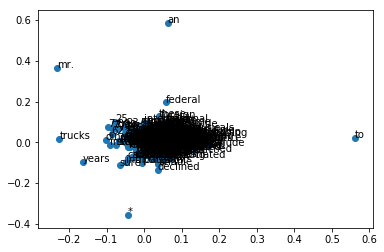

In [188]:
chosen_index = np.random.choice(8000, 500, replace=False)
chosen_embedding = word_embedding[chosen_index]
x = chosen_embedding[:,0]
y = chosen_embedding[:,1]

plt.scatter(x,y)
for i in range(len(chosen_index)):
    plt.annotate(id_dict[chosen_index[i]],xy=(x[i],y[i]))
plt.savefig("Plot_embedding")
plt.show()